In [1]:
import numpy as np
import os
import shutil
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import h5py
import matplotlib.pyplot as plt
import gc

%matplotlib inline

In [2]:
copa = np.array([np.zeros((3,3)),np.ones((3,3))]).T

In [3]:
copa[...,1]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [4]:
def load_images(path, name_dir='C30keV', n_pols=8):
    """
    Loads images into numpy array of shape (N,h,w,n_pols)
    
    Arguments:
    path -- path to the directory with images
    name_dir -- name of the particular directory with signal or bckg samples
    n_pols -- number of polarizations (channels) of each image
    
    Returns:
    images -- numpy array with N images of shape (h,w) with n_pols channels
    """

    img_ind = []
    path = path+name_dir+"/csvs/"
    img_names = os.listdir(path)
    for name in img_names:
        img_ind.append(list(filter(None, re.split('[_.^a-z]',name))))
    img_ind = pd.DataFrame(np.array(img_ind), columns=['HeaderID','GrainID','ClusterID','Pol'])
    img_ind = img_ind.sort_values(by=['HeaderID','GrainID','Pol'])
    for hd in np.unique(img_ind['HeaderID']):
        hd_imgs = img_ind[ img_ind['HeaderID']==hd ]
        for grain in np.unique(hd_imgs['GrainID']):
            grain_imgs = hd_imgs[ hd_imgs['GrainID']==grain ]
            if grain_imgs.shape[0]!=n_pols:
                img_ind = img_ind.drop(grain_imgs.index)
    img_names = []
    for name in img_ind.values:
        img_names.append(name[0]+'_gr'+name[1]+'_cl'+name[2]+'_pol'+name[3]+'.csv')
    
    gc.collect()
    i=0
    im_array = []
    for name in img_names:
        if i==0:
            tmp_im = []
            tmp_im.append(pd.read_csv(path+name, header=None).drop(32, axis=1).values)
        else: tmp_im.append(pd.read_csv(path+name, header=None).drop([0,33], axis=1).drop(32,axis=0).values)
        i+=1
        if i==n_pols:
            im_array.append(np.array(tmp_im, dtype=np.uint8).T)
            i=0
            gc.collect()
    return np.array(im_array)

In [6]:
def clean_zero_images(data, bad = None, class_name='C100keV'):
    """
    Removes images (or any entries) mentioned as 'bad', or containing zero pixels (if 'bad' is not specified)
    
    Arguments:
    data -- NumPy array with data to be cleaned
    bad -- list of indices to be removed. If None - images containing zero pixels are removed
    class_name -- str, name of the data used for saving the 'bad' list, if 'bad' is not specified
    
    Returns:
    data -- NumPy array with 'bad' items removed
    """
    if bad is None:
        bad = []
        for i in np.arange(data.shape[0]):
            if not data[i].all():
                bad.append(i)
        np.savetxt('bad_edge_'+class_name+'.txt',bad,fmt='%d')
        print(class_name+' bad samples: ',len(bad))
    mask = np.ones(data.shape[0],dtype=bool)
    
    mask[bad] = False
    return data[mask,...]

In [7]:
path = "/home/scanner-ml/Artem/"
class_names = ['C30keV','C60keV','gamma']
n_pols = 8

In [8]:
'''
%%time
C30 = load_images(path, 'C30keV')
C30 = clean_zero_images(C30, class_name='C30keV')
gc.collect()
C60 = load_images(path, 'C60keV')
C60 = clean_zero_images(C60, class_name='C60keV')
gc.collect()
C100 = load_images(path, 'C100keV/C1')
C100 = clean_zero_images(C100, class_name='C100keV')
gc.collect()
C100_2 = load_images(path, 'C100keV/C2')
C100_2 = clean_zero_images(C100_2, class_name='C100keV')
gc.collect()
gamma = load_images(path, 'gamma')
gamma = clean_zero_images(gamma, class_name='gamma')
gc.collect()

#if os.path.isfile('samples.h5'):
#    os.remove('samples.h5')

with h5py.File('samples.h5','a') as datafile:
    datafile.create_dataset('C30keV', data=C30)
    datafile.create_dataset('C60keV', data=C60)
    datafile.create_dataset('C100keV', data=np.vstack((C100,C100_2)))
    datafile.create_dataset('gamma', data=gamma)
    
print('gamma samples: ',gamma.shape, '\t', getsizeof(gamma)//1024**2, 'Mb')
print('C100keV_1 samples: ',C100.shape, '\t', getsizeof(C100)//1024**2, 'Mb')
print('C100keV_2 samples: ',C100_2.shape, '\t', getsizeof(C100_2)//1024**2, 'Mb')
print('C60keV samples: ',C60.shape, '\t', getsizeof(C60)//1024**2, 'Mb')
print('C30keV samples: ',C30.shape, '\t', getsizeof(C30)//1024**2, 'Mb')
'''
'datasamples'

'datasamples'

In [15]:
'''
%%time
if os.path.isfile('dataset.h5'):
    os.remove('dataset.h5')
with h5py.File('dataset.h5','a') as datafile:
    with h5py.File('samples.h5','r') as sampfile:
        for k in sampfile.keys():
            datas = sampfile[k][...]
            train, test = train_test_split(datas, test_size=0.15)
            datafile.create_dataset(k+'/train', data=train)
            datafile.create_dataset(k+'/test', data=test)
            gc.collect()
    print(list(datafile.keys()))
'''
'train_test_split'

'train_test_split'

In [14]:
with h5py.File('dataset.h5','r') as datafile:
    for k in datafile.keys():
        for p in datafile[k].keys():
            print(k+'/'+p+'\t', datafile[k+'/'+p].shape)

C100keV/test	 (22425, 32, 32, 8)
C100keV/train	 (127075, 32, 32, 8)
C30keV/test	 (17493, 32, 32, 8)
C30keV/train	 (99125, 32, 32, 8)
C60keV/test	 (18670, 32, 32, 8)
C60keV/train	 (105795, 32, 32, 8)
gamma/test	 (19329, 32, 32, 8)
gamma/train	 (109528, 32, 32, 8)


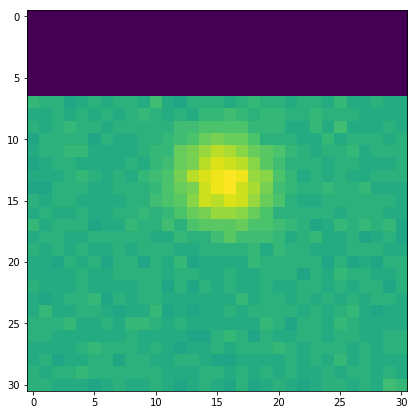

In [86]:
#example of bad image
plt.figure(figsize=(7,7))
plt.imshow(X[191,...,0])